# Setup

In [1]:
!rm *.csv # Removendo dados anteriores
!rm -R figs # Removendo pasta de figuras
!rm -R tabs # Removendo pasta de tabelas
!mkdir figs # Criando pasta para salvar figuras
!mkdir tabs # Criando pasta para salvar tabelas
!ls

Benchmark.html	 Benchmark.Rmd	figs		       tabs
Benchmark.ipynb  Clean.ipynb	SeriesTemporais.Rproj


# Introdução

Esta rotina ajusta um modelo de séries temporais. 
Será testado se o investimento residencial ($I_h$) depende da <u>taxa própria de juros</u> dos imóveis, ou seja,

$$
I_h = f(r_{mo}, p_h)
$$
em que

- $I_h$ Investimento residencial

  + **Série:** PRFI
  + Com ajuste sazonal
  + Trimestral
  
- $r_{mo}$ taxa de juros das hipotecas
  + **Série:** MORTGAGE30US
  - Sem ajuste sazonal
  - Semanal (encerrado às quintas feiras)

- $p_h$ Inflação de imóveis: Índice Case-Shiller

  + **Série:** CSUSHPISA
  + Com ajuste sazonal, Jan 2000 = 100
  + Mensal
  
**Nota:** Uma vez que pretende-se utilizar os resultados obtidos deste modelo em um trabalho futuro, os resultados serão checados tanto em python quanto em gretl, ambos softwares livres.

# Carregando pacotes

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

# Pacotes gerais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
# Pacotes estatísticos

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Pacotes para importação de dados

import pandas_datareader.data as web
from scipy.stats import yeojohnson

# Configurações do notebook

plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2019, 7, 1)

# Importando dados

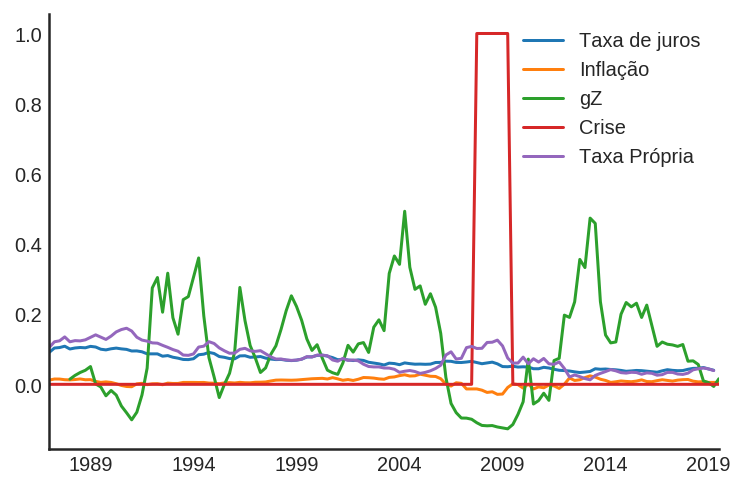

,Taxa de juros,Inflação,gZ,Crise,Taxa Própria,d_Taxa Própria,d_gZ,d_Inflação,d_Taxa de juros
,,,,,,,,,
2018-06-30,0.045446,0.009025,0.066893,0,0.041362,0.009487,0.001012,-0.004785,0.002623
2018-09-30,0.045669,0.007014,0.056555,0,0.044372,0.003010,-0.010338,-0.002011,0.000223
2018-12-31,0.047846,0.007525,0.009721,0,0.046550,0.002178,-0.046833,0.000511,0.002177
2019-03-31,0.043738,0.005433,0.004754,0,0.043991,-0.002559,-0.004968,-0.002092,-0.004108
2019-06-30,0.040108,0.005540,-0.006007,0,0.039136,-0.004855,-0.010761,0.000107,-0.003631


In [3]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Investimento residencial", 
    "Preço dos imóveis", 
    "Taxa de juros",
]
df.index.name = ""

df['Taxa de juros'] = df['Taxa de juros'].divide(100)
df['Preço dos imóveis'] = df['Preço dos imóveis']/df['Preço dos imóveis'][0]
df["Inflação"] = df["Preço dos imóveis"].pct_change(12)
df = df.resample('Q').mean()

df["Taxa Própria"] = ((1+df["Taxa de juros"])/(1+df["Inflação"])) -1
df['Taxa Própria'], *_ = yeojohnson(df['Taxa Própria'])

df['gZ'], *_ = yeojohnson(df["Investimento residencial"].pct_change(4))

df["Crise"] = [0 for i in range(len(df["gZ"]))]
for i in range(len(df["Crise"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crise"][i] = 1

df.to_csv("Dados_yeojohnson.csv", )

df = df[["Taxa de juros", "Inflação", "gZ", "Crise", "Taxa Própria"]]
df.plot()
sns.despine()
plt.show()

df["d_Taxa Própria"] = df["Taxa Própria"].diff()
df["d_gZ"] = df["gZ"].diff()
df["d_Inflação"] = df["Inflação"].diff()
df["d_Taxa de juros"] = df['Taxa de juros'].diff()
df = df.dropna()
df.tail()

# Teste de raíz unitária

In [4]:
def testes_raiz(df=df["gZ"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='série original')
    df.diff().plot(ax=ax[1], title='série em diferença')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Investimento residencial ($g_Z$)

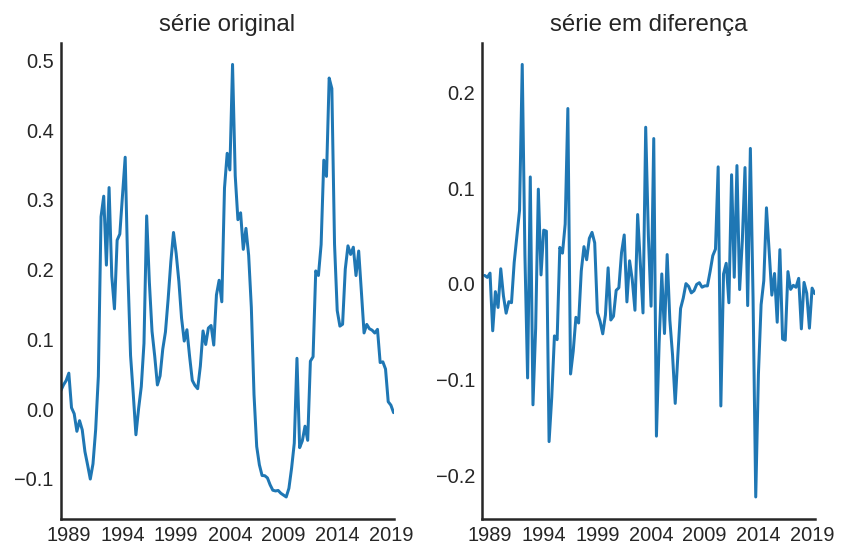

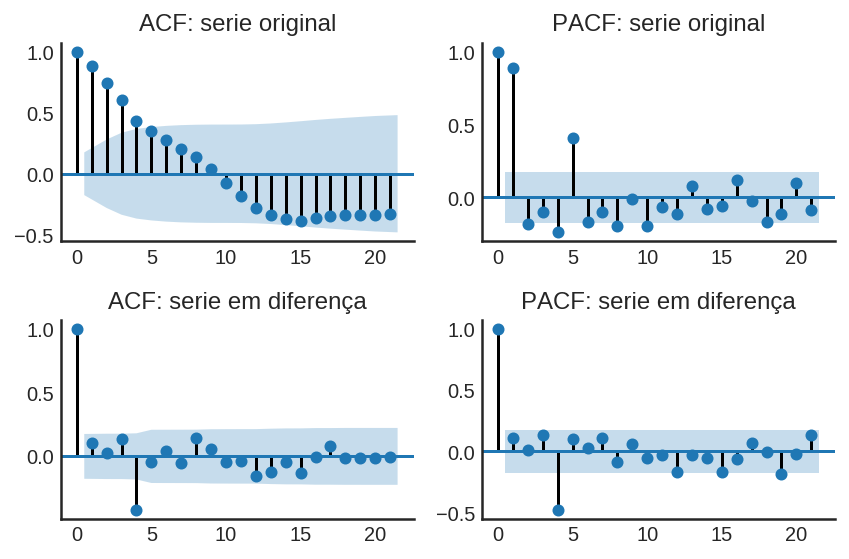


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -3.934
P-value                         0.392
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -7.919
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.312
P-value                         0.014
Lags                                7
------

In [5]:
testes_raiz(df=df['gZ'])

**Conclusão:** Série é fracamente estacionária.

## Taxa própria

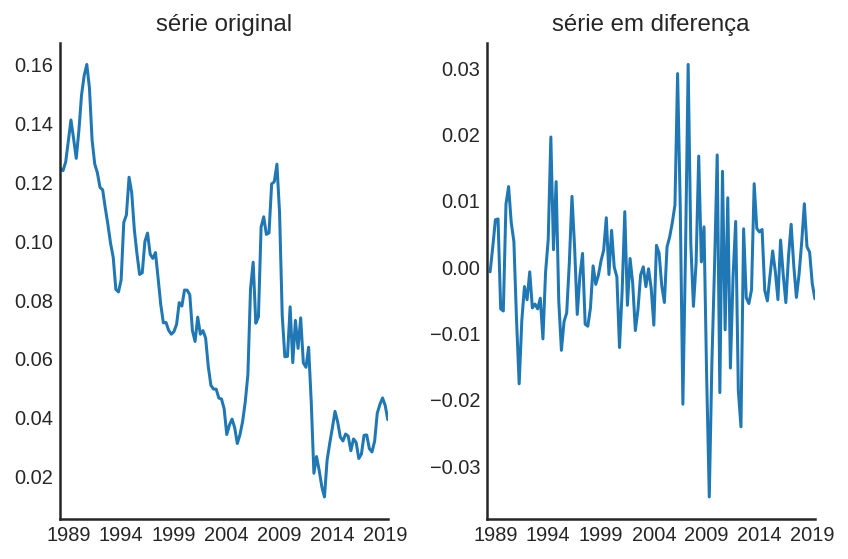

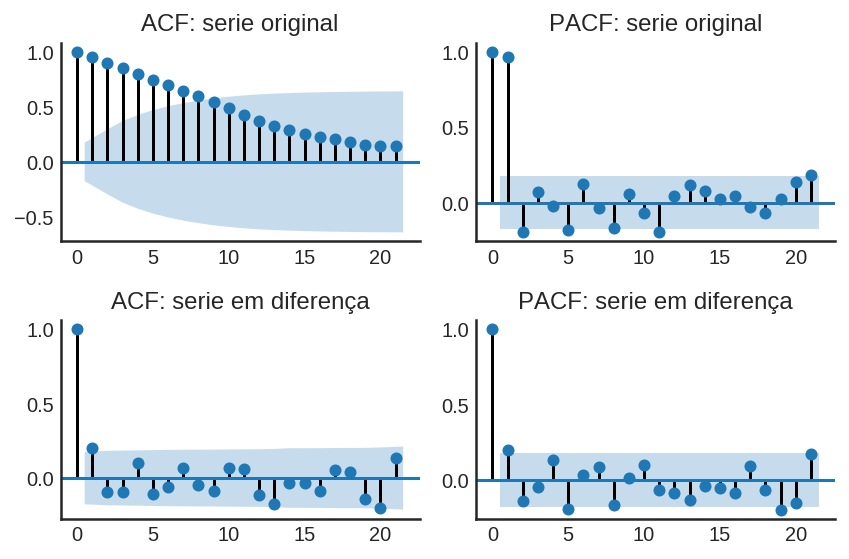


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -4.722
P-value                         0.067
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -6.296
P-value                         0.001
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.891
P-value                         0.336
Lags                                1
------

In [6]:
testes_raiz(df['Taxa Própria'])

**Conclusão:** Será tomada em primeira diferença.

## Inflação

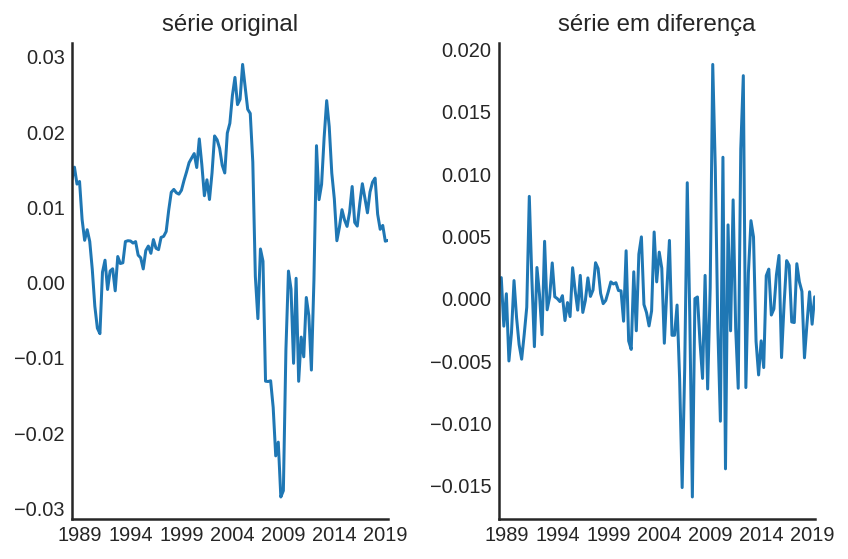

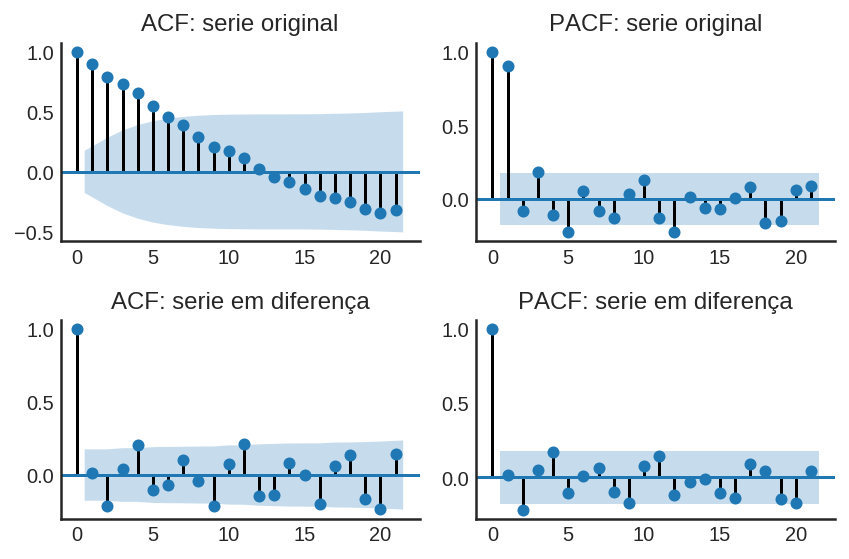


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -5.338
P-value                         0.008
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                -10.100
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.768
P-value                         0.063
Lags                                4
------

In [7]:
testes_raiz(df['Inflação'])

## Taxa de juros das hipotecas

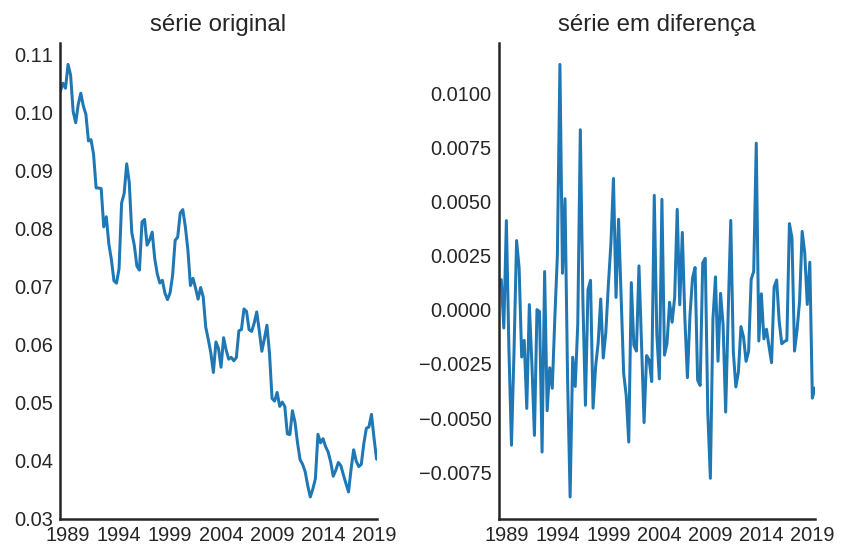

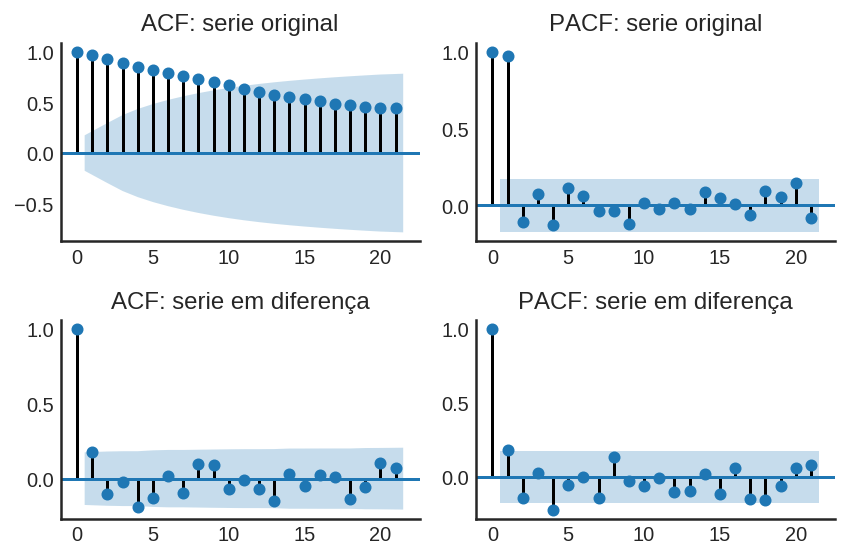


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -4.443
P-value                         0.239
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -7.121
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.641
P-value                         0.027
Lags                  

In [8]:
testes_raiz(df['Taxa de juros'], original_trend='ct')

## Investimento residencial  - Inflação de imóveis

Resta testar se existe alguma relação de longo prazo entre inflação de imóveis e investimento residencial.

Testando: 

$$
y = g_Z - \text{Infla} 
$$


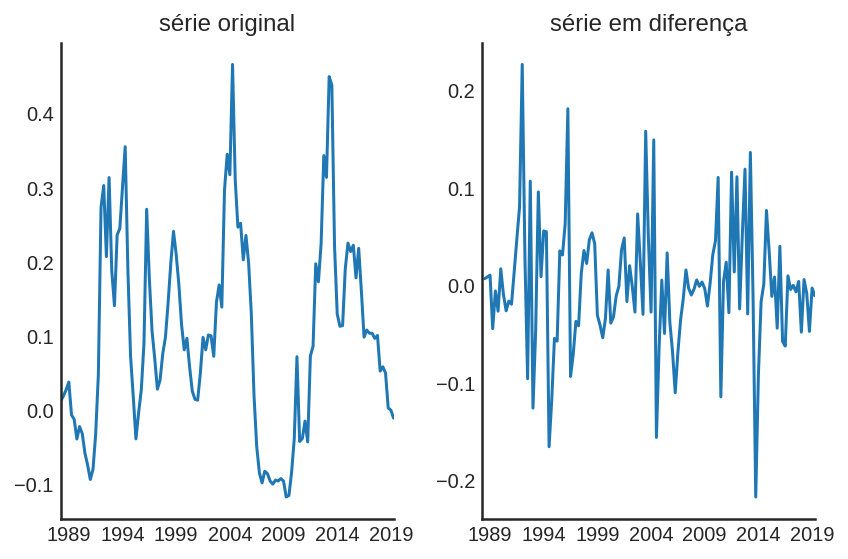

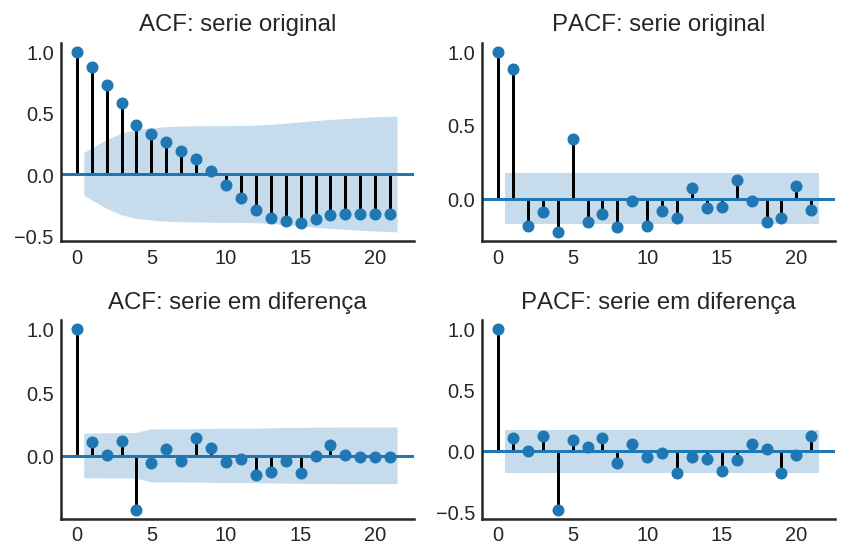


ZIVOT ANDREWS
        Zivot-Andrews Results        
Test Statistic                 -3.854
P-value                         0.444
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 

        Zivot-Andrews Results        
Test Statistic                 -8.066
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.334
P-value                         0.013
Lags                                7
------

In [9]:
testes_raiz(df=df["gZ"] - df["Inflação"])

# Teste de cointegração

In [10]:
def cointegracao(ts0, ts1, trend = 'c', signif = 0.05):
  result = coint(ts0, ts1, trend = trend)
  print('Null Hypothesis: there is NO cointegration')
  print('Alternative Hypothesis: there IS cointegration')
  print('t Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  if result[1] < signif:
    print('REJECT null Hypothesis: there IS cointegration')
  else:
    print('FAIL to reject Null Hypothesis: there is NO cointegration')

In [11]:
def johansen(ts, det_order = 0, k_ar_diff = 2, signif = 0.05):
  """
  ts = ts dataframe
  det_order = similar to coint_johansen function
    - (-1): no deterministic terms
    - 0: constant term
    - 1: linear trend
  k_ar_diff = similar to coint_johansen function
  signif = 0.1, 0.05, 0.01
  """
  var = len(ts.columns)
  result = coint_johansen(
      endog = ts, 
      det_order = det_order,
      k_ar_diff = k_ar_diff
  )

  p = [i for i in range(var)]
  
  print("Null hypothesis: number of cointegration vectors is r* = {}".format(k_ar_diff))
  print('Alternative (Trace): r* > {}'.format(k_ar_diff))
  print('\n')
  for i in range(var):
    print("Test for variable " + str(ts.columns[i]).upper())
    print("TRACE test")
    print('Statistic: %f' % result.lr1[i])
    print('Critical Values:')
    print('\t 10%: ', result.cvt[i][0])
    print('\t 5%: ', result.cvt[i][1])
    print('\t 1%: ', result.cvt[i][2])
    
    if signif == 0.05:
      p[i] = result.cvt[i][1]
    elif signif == 0.01:
      p[i] = result.cvt[i][2]
    else:
      p[i] = result.cvt[i][0]
      
  print("For a significant level of {}, REJECT null hypothesis? {}".format(signif, np.sum(result.lr1 > p) == var))

In [12]:
def testes_cointegracao(
    ts0,
    ts1,
    ts=df,
    signif = 0.05
):
    print(f'Testando para: {ts0.columns}, {ts1.columns}, {ts.columns}')
    
    print('='*10)
    print('TESTES DE ENGEL GRANGER\n')
    cointegracao(ts0=ts0, ts1=ts1, signif=signif)
    print('='*10)
    
    print('\nTESTES DE ENGEL JOHANSEN\n')
    for r in range(len(ts.columns)):
        print('='*10)
        print(f'\nTESTANDO PARA r =  {r} \n')
        johansen(ts, k_ar_diff = r)
    

In [13]:
testes_cointegracao(ts0=df[['gZ']],
                    ts1=df[['Taxa Própria']],
                    ts=df[['Taxa Própria', 'gZ']],
                    signif=0.05)

Testando para: Index(['gZ'], dtype='object'), Index(['Taxa Própria'], dtype='object'), Index(['Taxa Própria', 'gZ'], dtype='object')
TESTES DE ENGEL GRANGER

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.061698
p-value: 0.496395
FAIL to reject Null Hypothesis: there is NO cointegration

TESTES DE ENGEL JOHANSEN


TESTANDO PARA r =  0 

Null hypothesis: number of cointegration vectors is r* = 0
Alternative (Trace): r* > 0


Test for variable TAXA PRÓPRIA
TRACE test
Statistic: 13.804677
Critical Values:
	 10%:  13.4294
	 5%:  15.4943
	 1%:  19.9349
Test for variable GZ
TRACE test
Statistic: 1.586244
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.05, REJECT null hypothesis? False

TESTANDO PARA r =  1 

Null hypothesis: number of cointegration vectors is r* = 1
Alternative (Trace): r* > 1


Test for variable TAXA PRÓPRIA
TRACE test
Statistic: 13.920726
Critical Values:
	 10%:  13.4294
	 5

In [14]:
testes_cointegracao(ts0=df[['gZ']],
                    ts1=df[['Inflação', 'Taxa de juros']],
                    ts=df[['Inflação', 'gZ', 'Taxa de juros']],
                    signif=0.05)

Testando para: Index(['gZ'], dtype='object'), Index(['Inflação', 'Taxa de juros'], dtype='object'), Index(['Inflação', 'gZ', 'Taxa de juros'], dtype='object')
TESTES DE ENGEL GRANGER

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.978834
p-value: 0.250162
FAIL to reject Null Hypothesis: there is NO cointegration

TESTES DE ENGEL JOHANSEN


TESTANDO PARA r =  0 

Null hypothesis: number of cointegration vectors is r* = 0
Alternative (Trace): r* > 0


Test for variable INFLAÇÃO
TRACE test
Statistic: 33.413500
Critical Values:
	 10%:  27.0669
	 5%:  29.7961
	 1%:  35.4628
Test for variable GZ
TRACE test
Statistic: 12.834981
Critical Values:
	 10%:  13.4294
	 5%:  15.4943
	 1%:  19.9349
Test for variable TAXA DE JUROS
TRACE test
Statistic: 0.844183
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.05, REJECT null hypothesis? False

TESTANDO PARA r =  1 

Null hypothesis: number of cointegratio

In [15]:
testes_cointegracao(ts0=df[['gZ']],
                    ts1=df[['Inflação']],
                    ts=df[['Inflação', 'gZ']],
                    signif=0.05)

Testando para: Index(['gZ'], dtype='object'), Index(['Inflação'], dtype='object'), Index(['Inflação', 'gZ'], dtype='object')
TESTES DE ENGEL GRANGER

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.216650
p-value: 0.067187
FAIL to reject Null Hypothesis: there is NO cointegration

TESTES DE ENGEL JOHANSEN


TESTANDO PARA r =  0 

Null hypothesis: number of cointegration vectors is r* = 0
Alternative (Trace): r* > 0


Test for variable INFLAÇÃO
TRACE test
Statistic: 20.865019
Critical Values:
	 10%:  13.4294
	 5%:  15.4943
	 1%:  19.9349
Test for variable GZ
TRACE test
Statistic: 5.691729
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.05, REJECT null hypothesis? True

TESTANDO PARA r =  1 

Null hypothesis: number of cointegration vectors is r* = 1
Alternative (Trace): r* > 1


Test for variable INFLAÇÃO
TRACE test
Statistic: 27.991744
Critical Values:
	 10%:  13.4294
	 5%:  15.4943
	 1%:

In [16]:
testes_cointegracao(ts0=df[['gZ']],
                    ts1=df[['Inflação']],
                    ts=df[['Inflação', 'Taxa de juros', 'gZ']],
                    signif=0.05)

Testando para: Index(['gZ'], dtype='object'), Index(['Inflação'], dtype='object'), Index(['Inflação', 'Taxa de juros', 'gZ'], dtype='object')
TESTES DE ENGEL GRANGER

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -3.216650
p-value: 0.067187
FAIL to reject Null Hypothesis: there is NO cointegration

TESTES DE ENGEL JOHANSEN


TESTANDO PARA r =  0 

Null hypothesis: number of cointegration vectors is r* = 0
Alternative (Trace): r* > 0


Test for variable INFLAÇÃO
TRACE test
Statistic: 33.413500
Critical Values:
	 10%:  27.0669
	 5%:  29.7961
	 1%:  35.4628
Test for variable TAXA DE JUROS
TRACE test
Statistic: 12.834981
Critical Values:
	 10%:  13.4294
	 5%:  15.4943
	 1%:  19.9349
Test for variable GZ
TRACE test
Statistic: 0.844183
Critical Values:
	 10%:  2.7055
	 5%:  3.8415
	 1%:  6.6349
For a significant level of 0.05, REJECT null hypothesis? False

TESTANDO PARA r =  1 

Null hypothesis: number of cointegration vectors is r* =

# VECM

In [17]:
from statsmodels.tsa.vector_ar.vecm import select_order

with open('./tabs/VECM_lag_order.tex','w') as fh:
    fh.write(select_order(df[["Taxa Própria", "gZ"]], maxlags=15).summary().as_latex_tabular(tile = "Selação ordem do VECM"))

select_order(df[["gZ", "Taxa Própria"]], maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,-14.81,-14.66*,3.693e-07,-14.75
1,-14.82,-14.58,3.655e-07,-14.72
2,-14.85,-14.50,3.569e-07,-14.71
3,-14.90,-14.46,3.371e-07,-14.72
4,-15.12,-14.57,2.728e-07,-14.90
5,-15.17*,-14.52,2.596e-07*,-14.91*
6,-15.13,-14.39,2.684e-07,-14.83
7,-15.14,-14.30,2.667e-07,-14.80
8,-15.13,-14.19,2.705e-07,-14.75
9,-15.08,-14.04,2.854e-07,-14.66


In [18]:
model = VECM(
    endog = df[["Taxa Própria", "gZ"]],
    k_ar_diff=5
)
results = model.fit()

with open('./tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Taxa Própria
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.Taxa Própria     0.2262      0.091      2.491      0.013       0.048       0.404
L1.gZ              -0.0166      0.015     -1.073      0.283      -0.047       0.014
L2.Taxa Própria    -0.1219      0.092     -1.318      0.187      -0.303       0.059
L2.gZ              -0.0102      0.013     -0.774      0.439      -0.036       0.016
L3.Taxa Própria    -0.1093      0.099     -1.104      0.269      -0.303       0.085
L3.gZ               0.0001      0.013      0.009      0.993      -0.025       0.025
L4.Taxa Própria     0.1664      0.097      1.708      0.088      -0.025       0.357
L4.gZ              -0.0143      0.013     -1.134      0.257      -0.039       0.010
L5.Taxa Própria    -0.2022      0.101     -2.008      0.045      -0.

## Pós Estimação

### Resíduos

In [19]:
def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1] < signif
    for j in range(k):
      print("Reject H0 on lag " ,j+1,"? ", result[j])
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results=results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

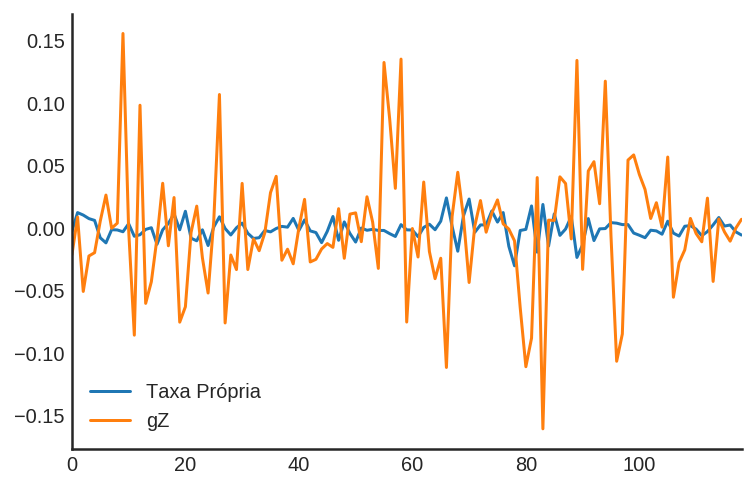

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         43.61          53.38   0.245 38
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         47.55          53.38   0.138 38
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?

In [20]:
residuals = analise_residuos()

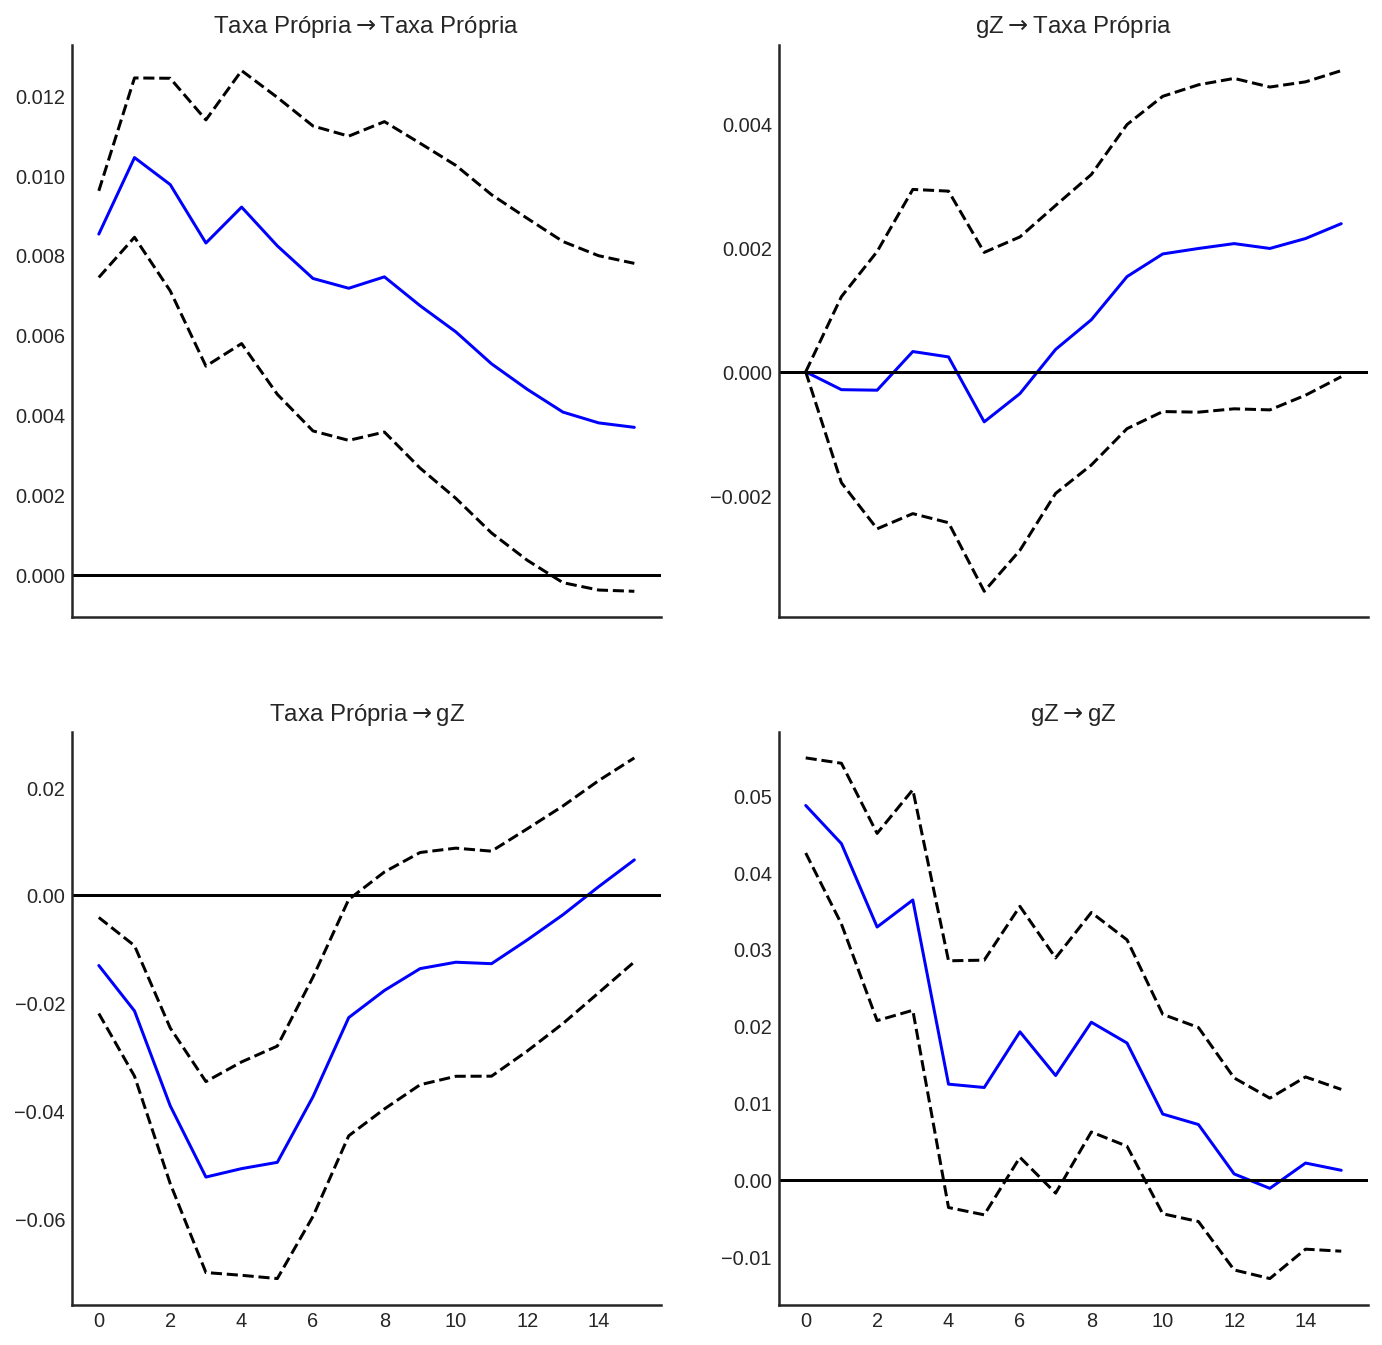

In [21]:
p = results.irf(15).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECMOrth.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

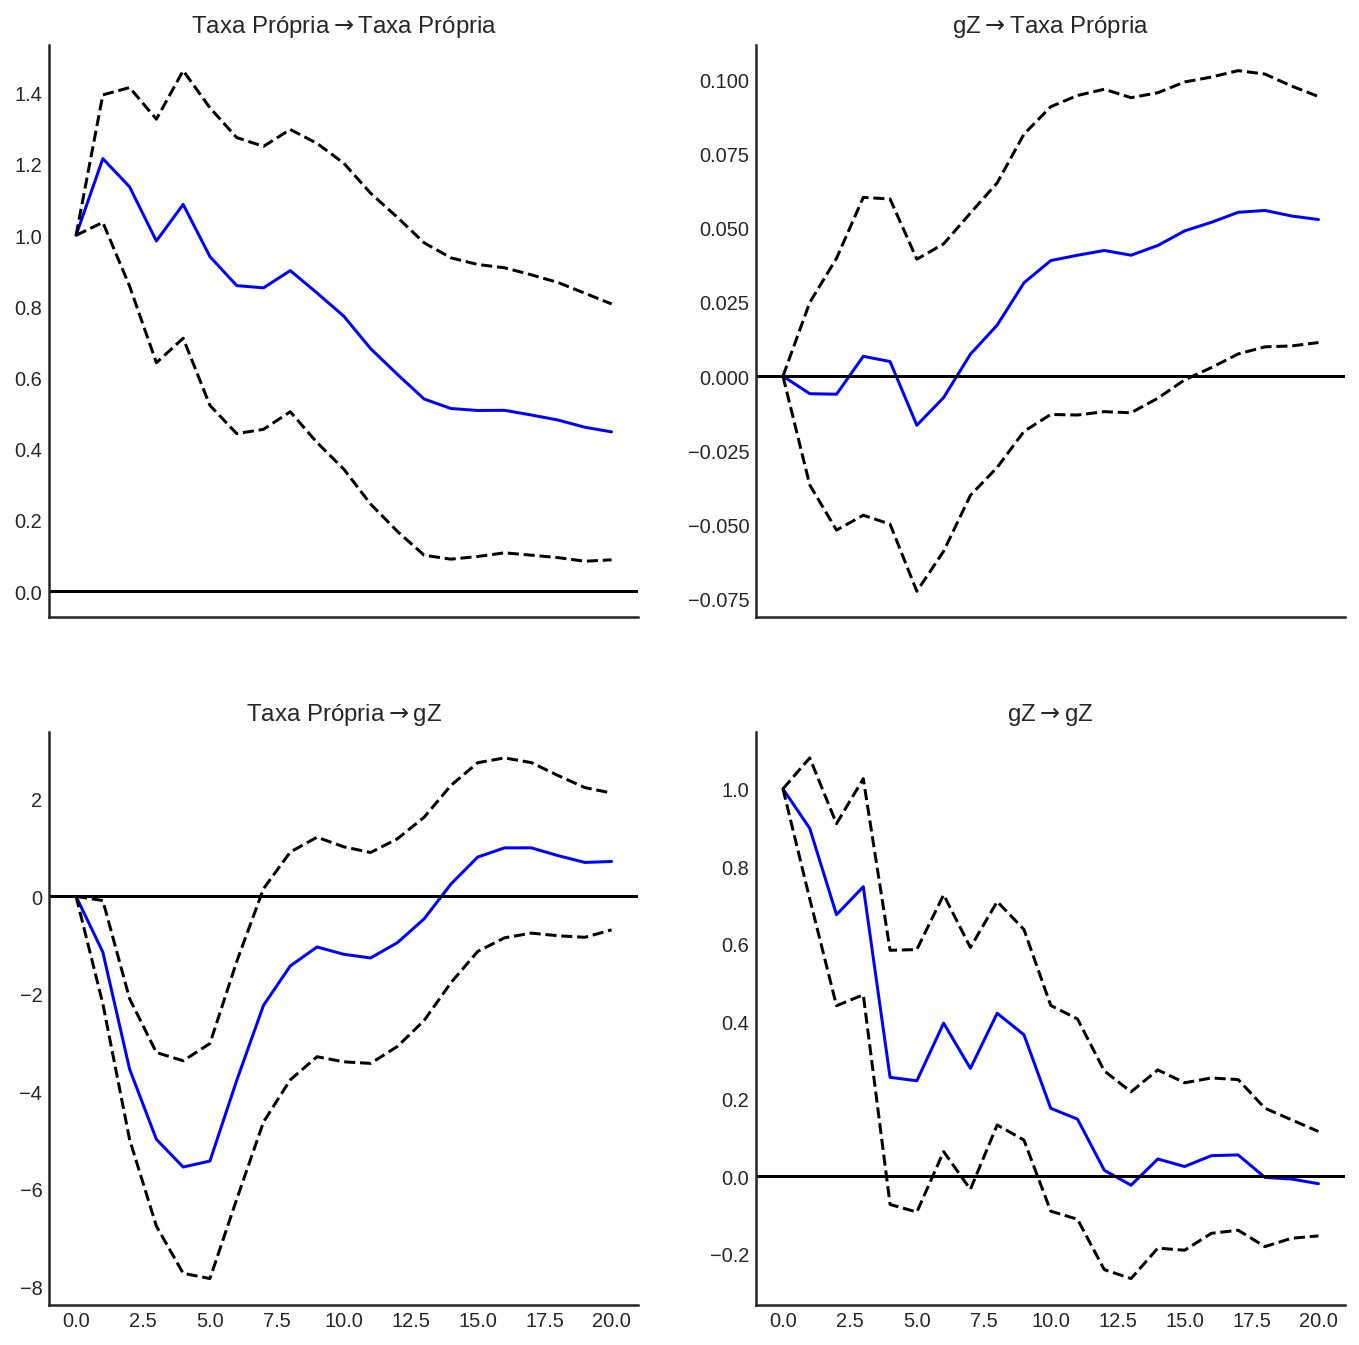

In [22]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

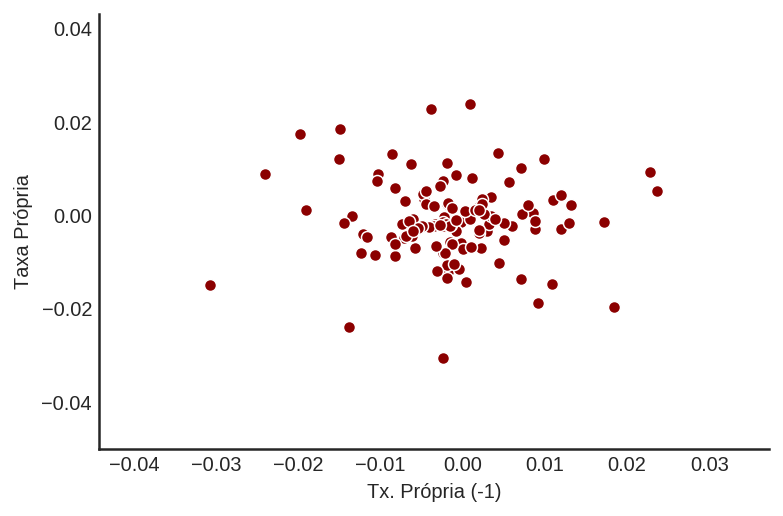

In [23]:
sns.scatterplot(y = residuals['Taxa Própria'], x = residuals['Taxa Própria'].shift(-1), color = 'darkred')
sns.despine()
plt.xlabel("Tx. Própria (-1)")
plt.show()

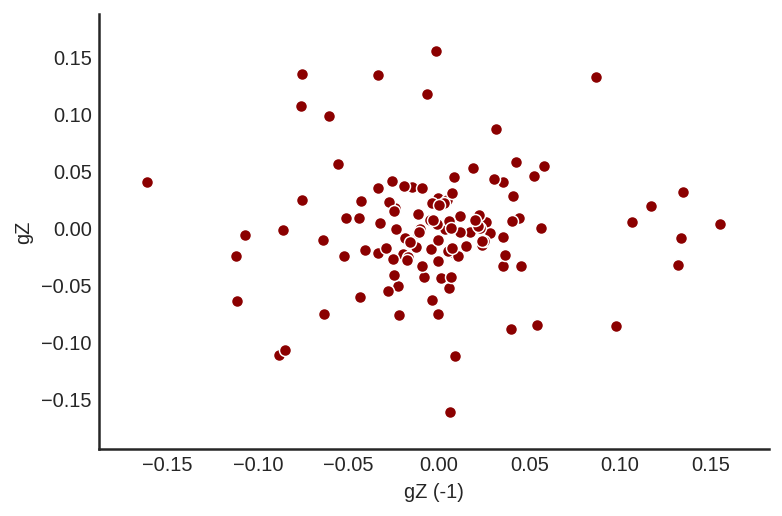

In [24]:
sns.scatterplot(y = residuals['gZ'], x = residuals['gZ'].shift(-1), color = 'darkred')
sns.despine()
plt.xlabel("gZ (-1)")
plt.show()

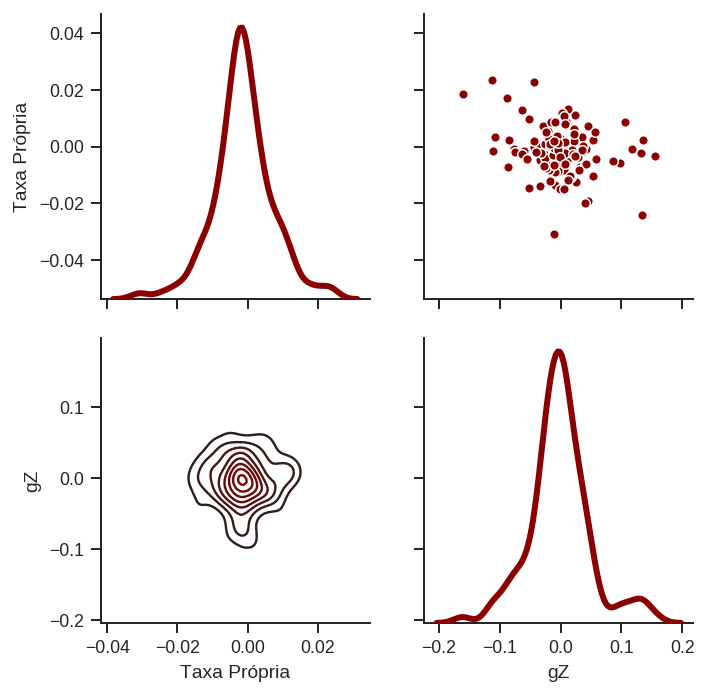

In [25]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## FEVD

corrigir!!

In [26]:
%%R
library(strucchange)
library(urca)

R[write to console]: Carregando pacotes exigidos: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Carregando pacotes exigidos: sandwich



In [27]:
%%R -o fevd_gz
library(tsDyn)
library(readr)
df <- read.csv("./Dados_yeojohnson.csv", encoding="UTF-8")
df <- df[,c(6,7)]
names(df) <- c("TaxaP", "gZ")
df <- na.omit(df[,c("TaxaP", "gZ")])
df <- ts(data = df, start = c(1987,01), frequency = 4)
model <- tsDyn::VECM(data = df, lag = 5, r = 1, estim = "ML")
fevd_gz = data.frame(tsDyn::fevd(model, 20)$gZ)

R[write to console]: Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [28]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$TaxaP)

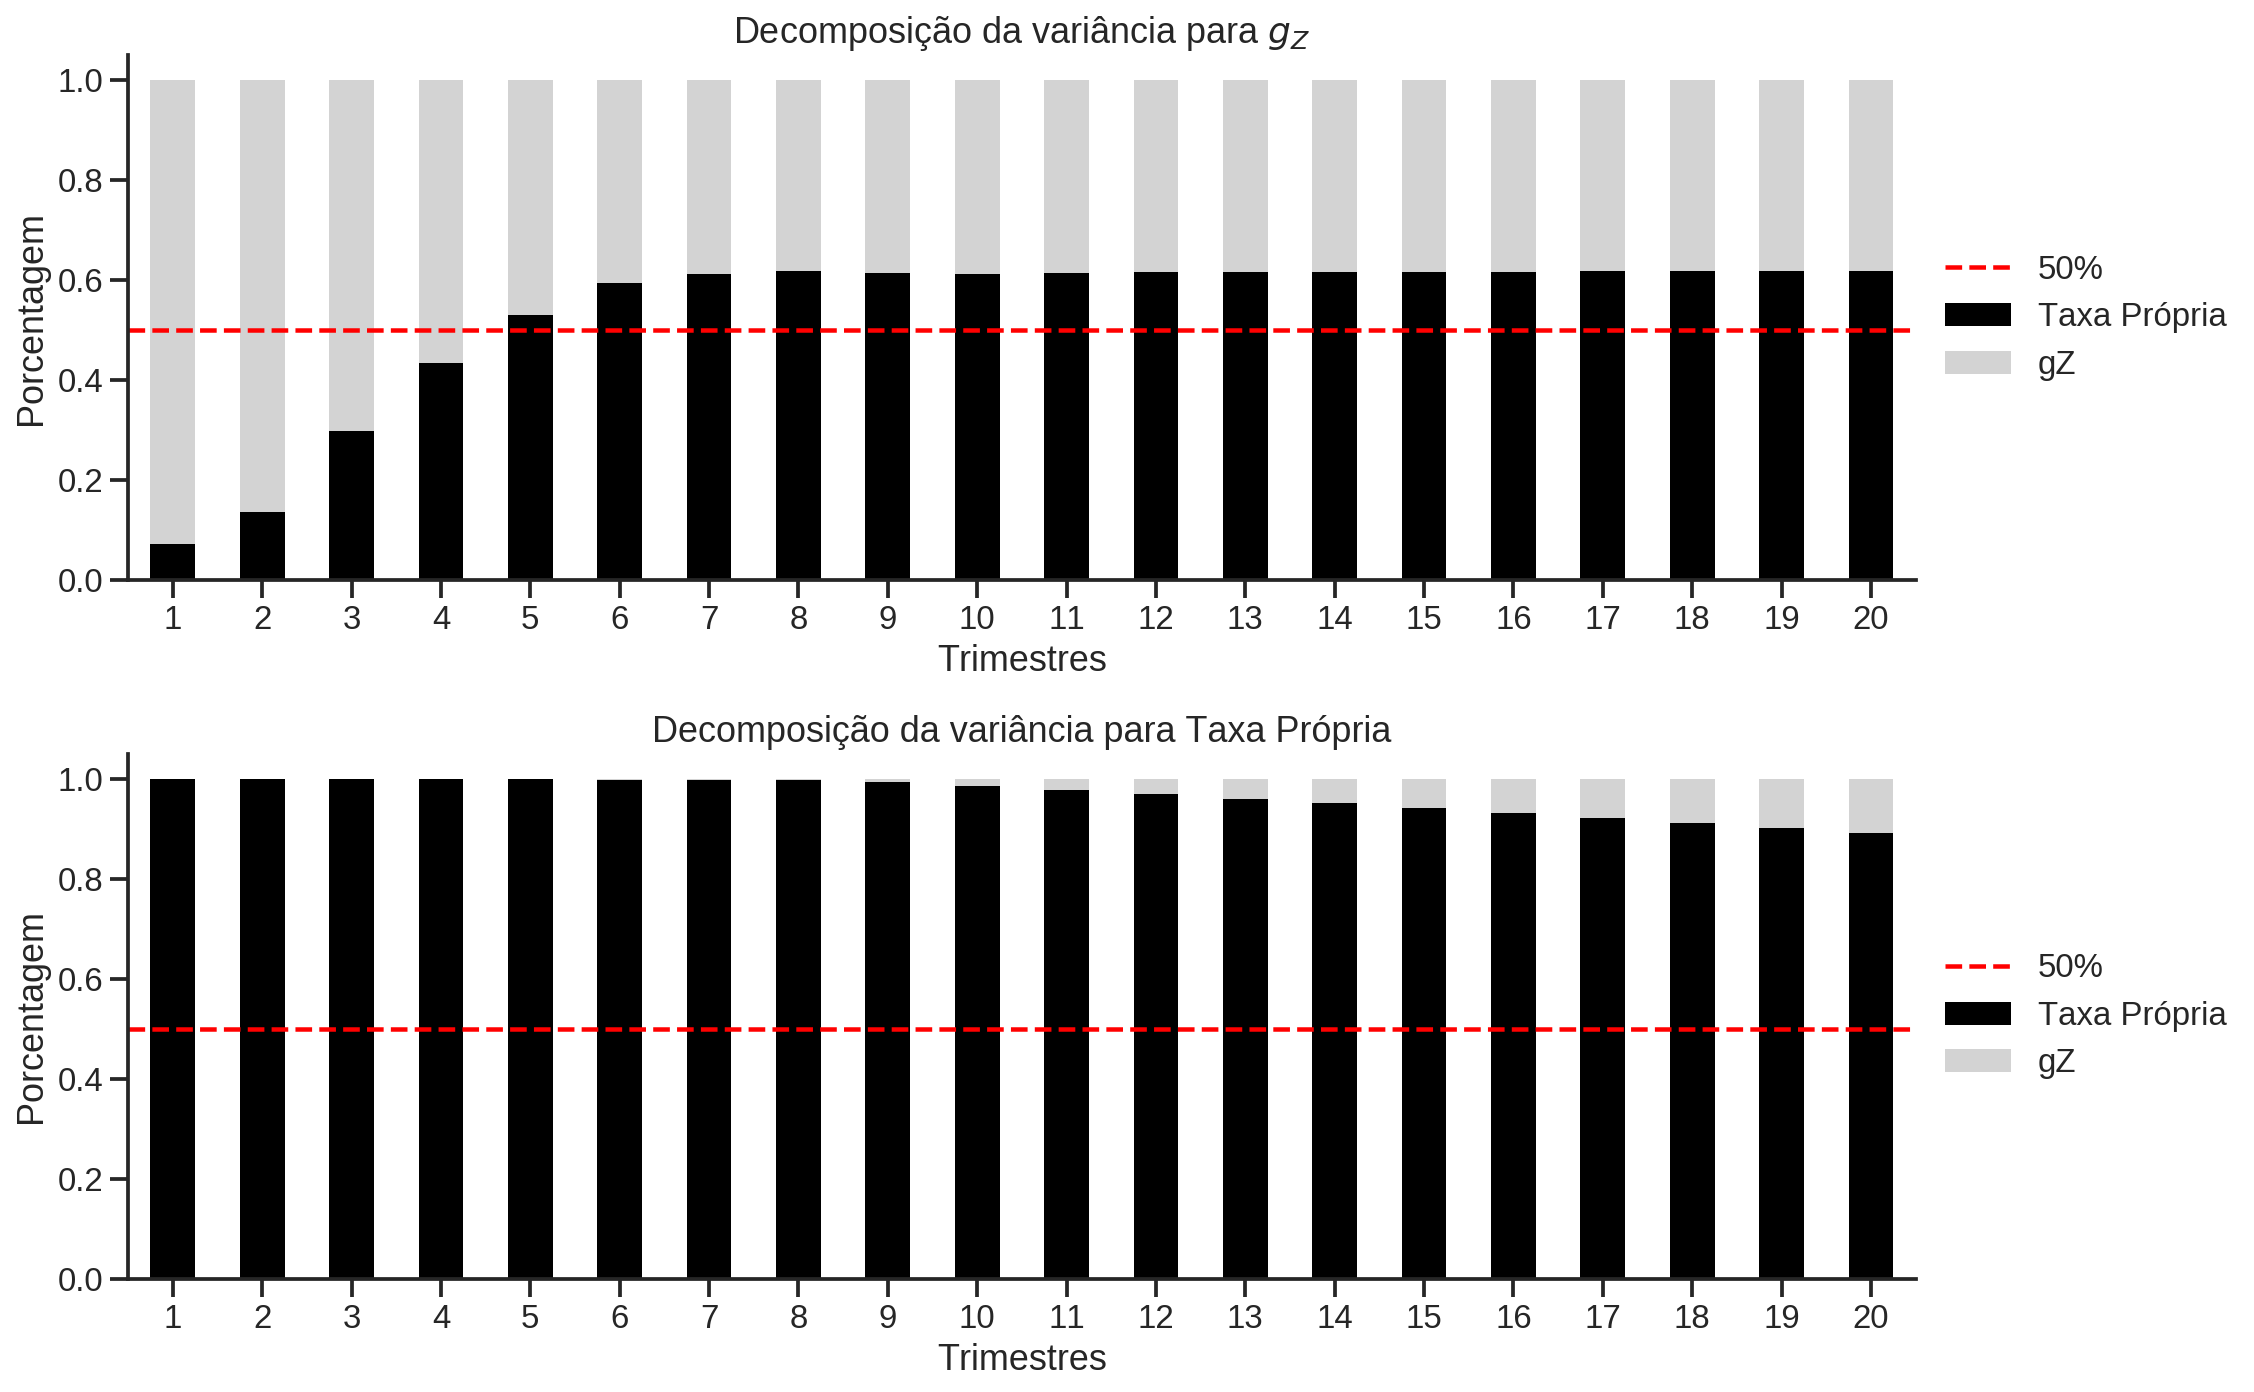

In [29]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gz.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Taxa Própria", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Taxa Própria", "gZ"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("./figs/FEVD_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

In [30]:
model = VAR(
    df[["d_Inflação", 'gZ']],
    exog=df[['Taxa de juros']]
)
print(model.select_order(maxlags=15).summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.41      -14.32   5.499e-07      -14.37
1       -15.91     -15.71*   1.238e-07      -15.83
2       -15.98      -15.68   1.151e-07      -15.86
3       -15.99      -15.59   1.142e-07      -15.83
4       -16.00      -15.51   1.128e-07      -15.80
5      -16.19*      -15.60  9.347e-08*     -15.95*
6       -16.19      -15.50   9.372e-08      -15.91
7       -16.13      -15.35   9.876e-08      -15.82
8       -16.10      -15.22   1.023e-07      -15.74
9       -16.09      -15.11   1.032e-07      -15.70
10      -16.05      -14.97   1.080e-07      -15.61
11      -16.03      -14.85   1.113e-07      -15.55
12      -15.98      -14.70   1.173e-07      -15.46
13      -15.93      -14.55   1.236e-07      -15.37
14      -15.89      -14.42   1.293e-07      -15.29
15      -15.84      -14.27   1.367e-07      -15.20
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [31]:
results = model.fit(ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           qui, 21, nov, 2019
Time:                     22:51:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.6548
Nobs:                     119.000    HQIC:                  -16.0432
Log likelihood:           660.663    FPE:                8.28238e-08
AIC:                     -16.3087    Det(Omega_mle):     6.63049e-08
--------------------------------------------------------------------
Results for equation d_Inflação
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.002167         0.001742            1.244           0.214
exog0                -0.026503         0.025310           -1.047           0.295
L1.d_Inflação         0.012030         0.104703        

## Inspeção

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

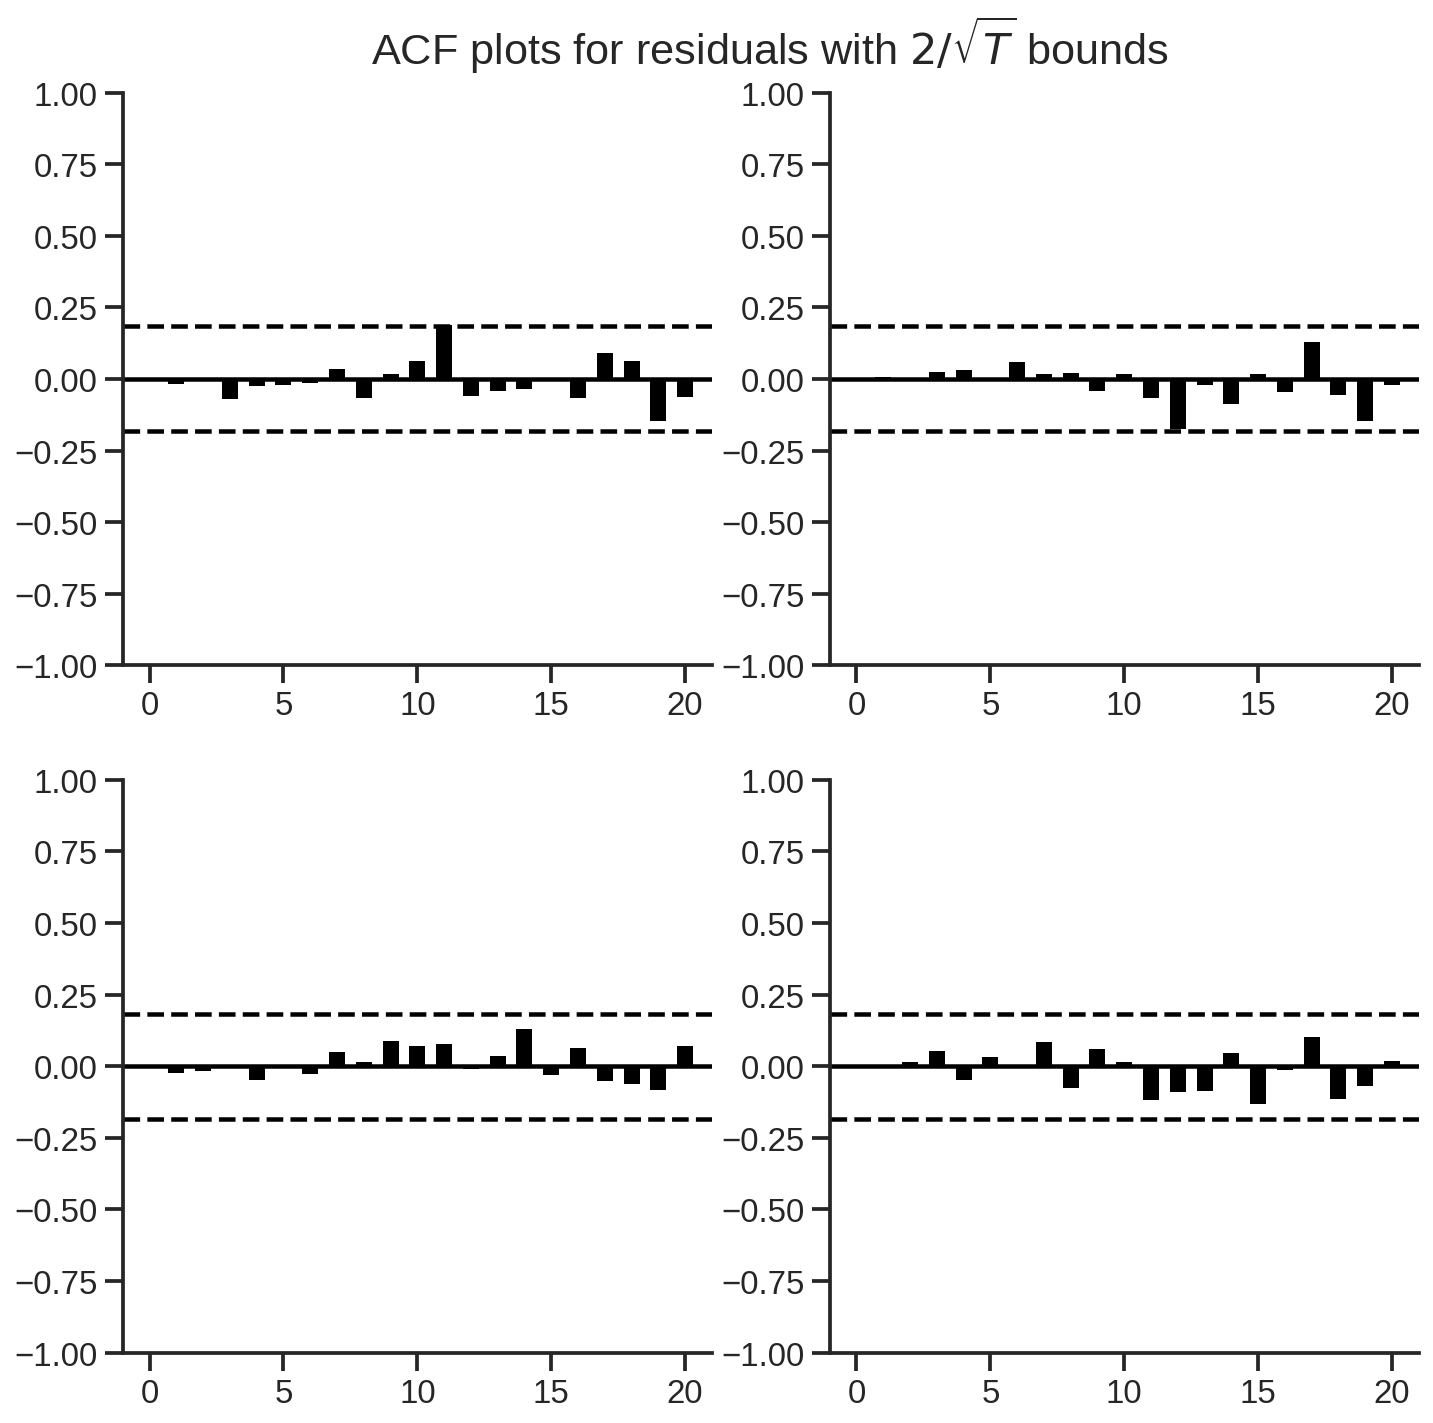

In [32]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação seria dos resíduos.

### Estabilidade

In [33]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.8172697394909394
0.8597766254218369
0.8597766254218369
0.8089998915201503
0.8089998915201503
0.5526542617030351
0.5526542617030351
0.8278419051092802
0.8278419051092802
0.767118044274271
0.767118044274271
0.6506285940725638
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

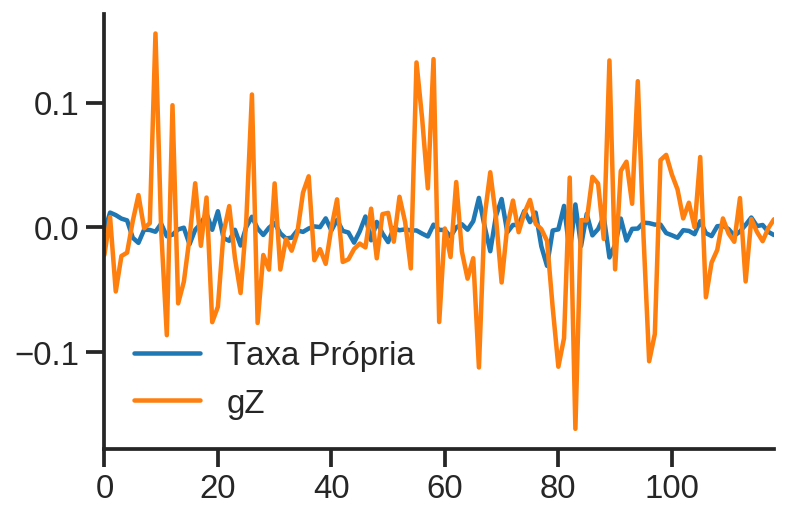

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         43.61          53.38   0.245 38
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         47.55          53.38   0.138 38
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  TAXA PRÓPRIA . Considering a significance level of 5.0 %
Reject H0 on lag  1 ?  False
Reject H0 on lag  2 ?  False
Reject H0 on lag  3 ?

In [34]:
residuals = analise_residuos()

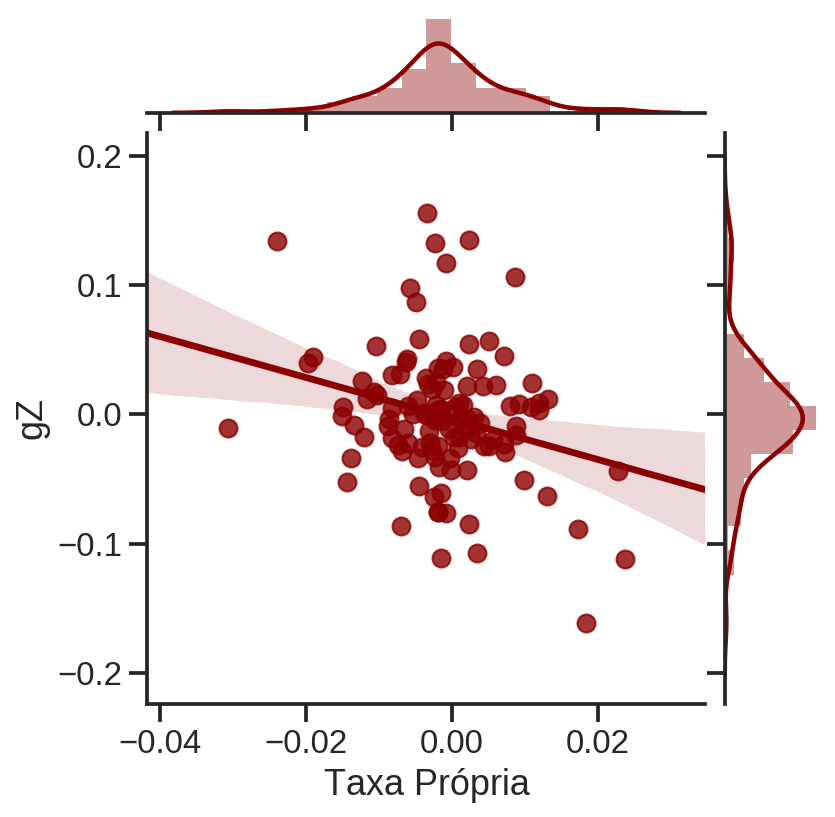

In [35]:
sns.set_context('talk')
ax = sns.jointplot(
    x = 'Taxa Própria', 
    y = 'gZ', 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

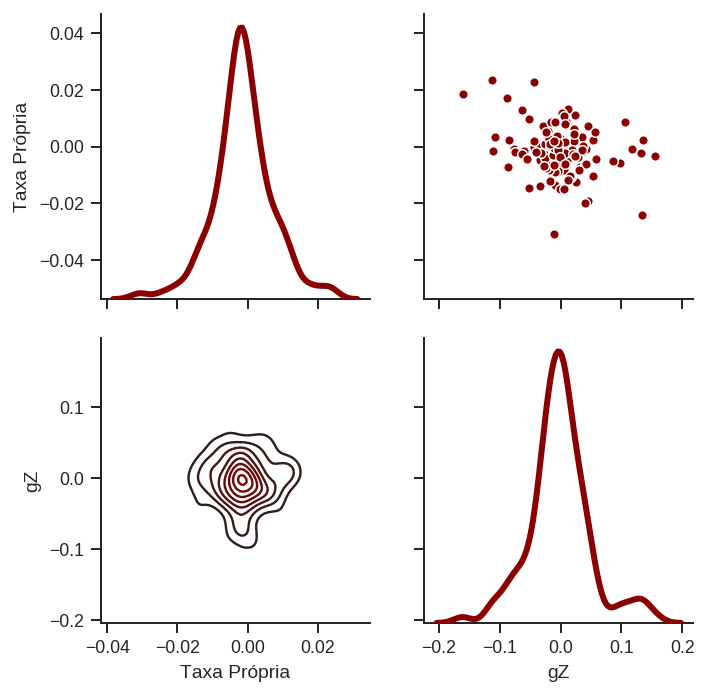

In [36]:
sns.set_context('paper')
g = sns.PairGrid(residuals, diag_sharey=False)
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("./figs/Residuos_4.png", dpi=300)

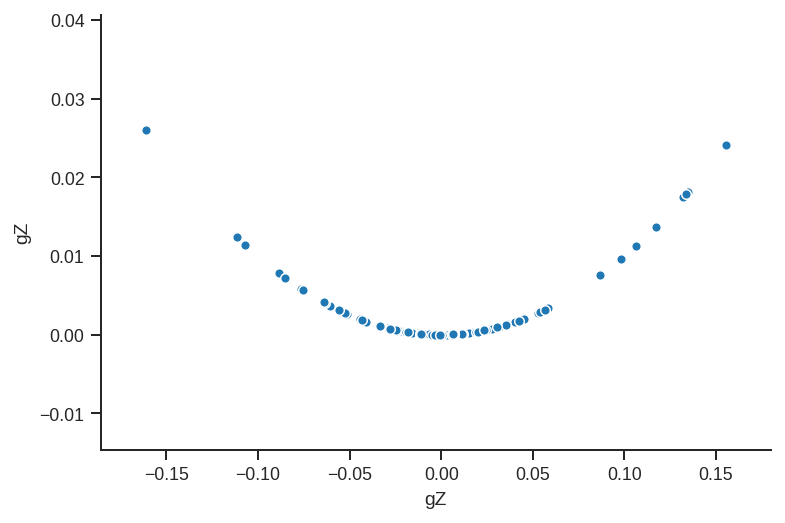

In [37]:
sns.scatterplot(x = residuals['gZ'], y = residuals['gZ']**2)
sns.despine()
plt.show()

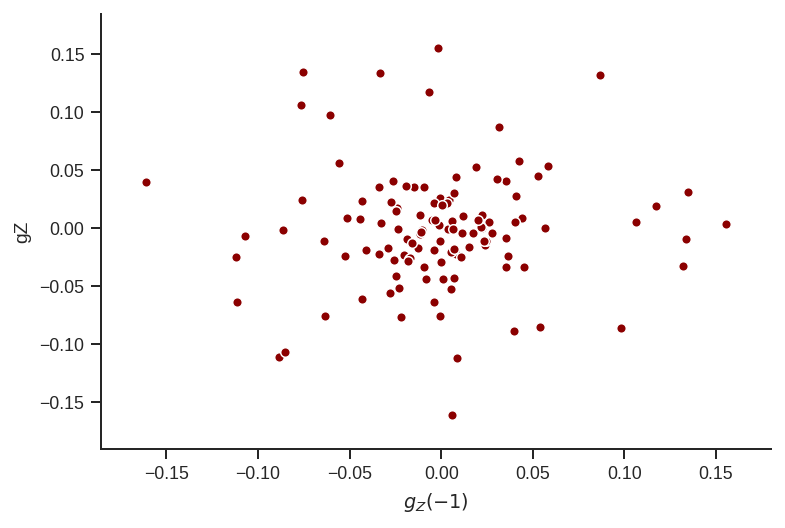

In [38]:
sns.scatterplot(
    y = residuals['gZ'], 
    x = residuals['gZ'].shift(-1), 
    color = 'darkred' 
)
sns.despine()
plt.xlabel("$g_Z(-1)$")
plt.show()

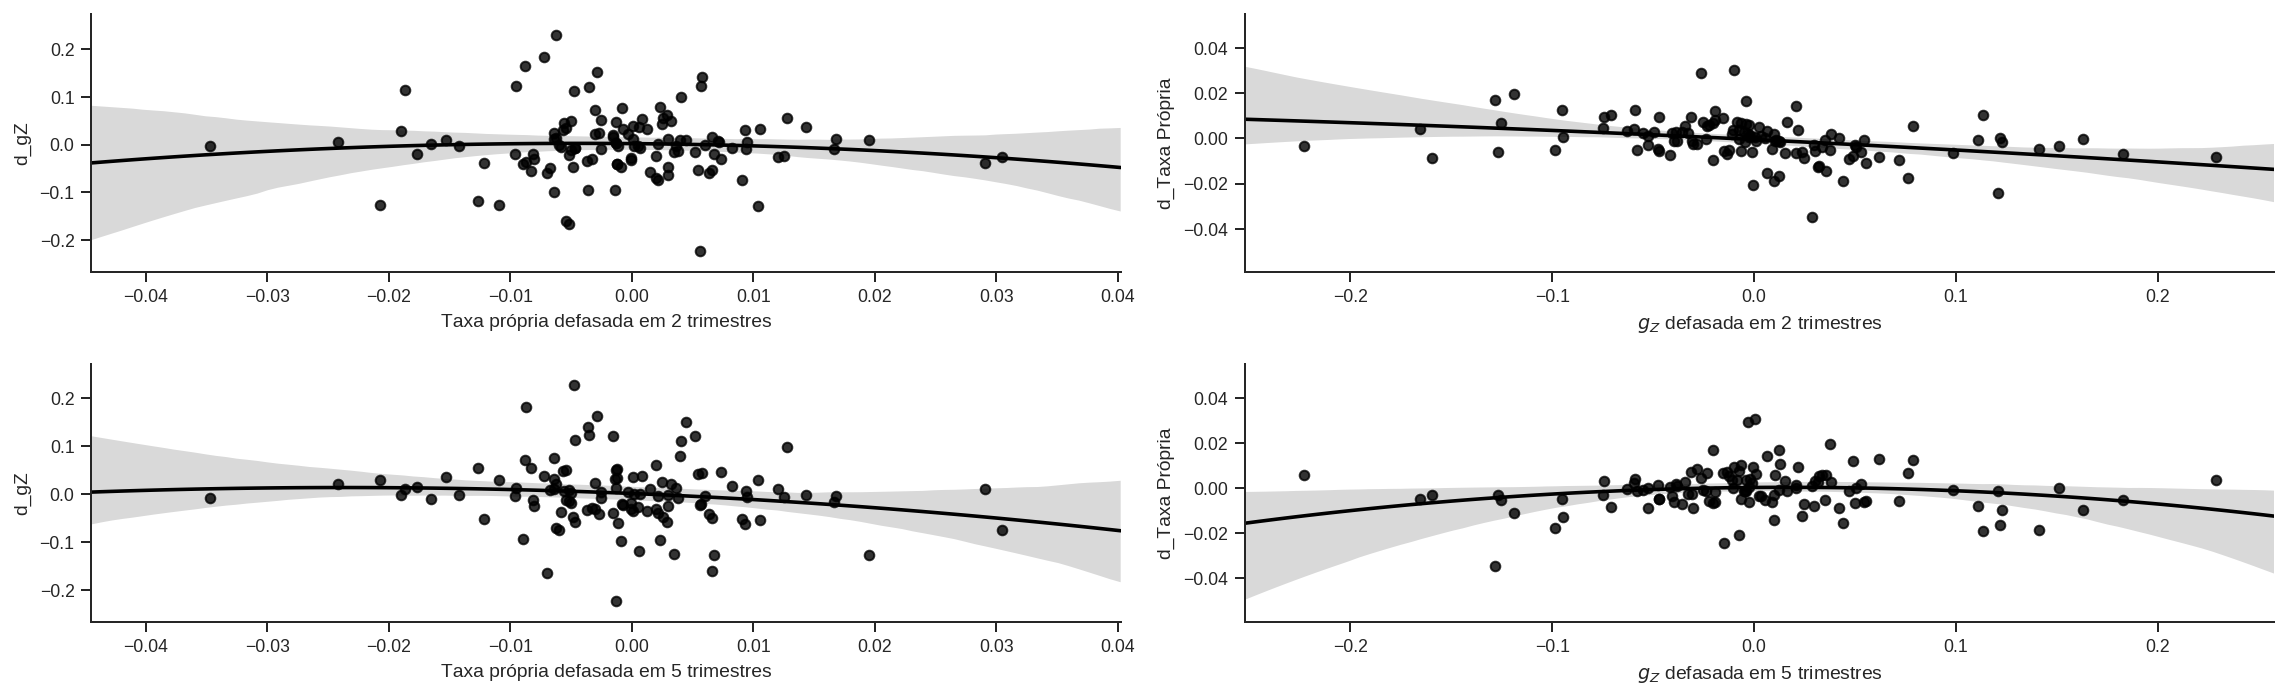

In [39]:
fig, ax = plt.subplots(2,2, figsize = (16,5))

trimestres = 2

sns.regplot(y = df["d_gZ"], x = df["d_Taxa Própria"].shift(-trimestres), color = 'black', ax = ax[0,0], order = 2)
ax[0,0].set_xlabel('Taxa própria defasada em {} trimestres'.format(trimestres))

sns.regplot(x = df["d_gZ"].shift(-trimestres), y = df["d_Taxa Própria"], color = 'black', ax = ax[0,1], order = 2)
ax[0,1].set_xlabel('$g_Z$ defasada em {} trimestres'.format(trimestres))


trimestres = 5

sns.regplot(y = df["d_gZ"], x = df["d_Taxa Própria"].shift(-trimestres), color = 'black', ax = ax[1,0], order = 2)
ax[1,0].set_xlabel('Taxa própria defasada em {} trimestres'.format(trimestres))

sns.regplot(x = df["d_gZ"].shift(-trimestres), y = df["d_Taxa Própria"], color = 'black', ax = ax[1,1], order = 2)
ax[1,1].set_xlabel('$g_Z$ defasada em {} trimestres'.format(trimestres))

sns.despine()
fig.tight_layout()
plt.show()
fig.savefig("./figs/Scatter_VECM.png", dpi = 300, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Função resposta ao impulso

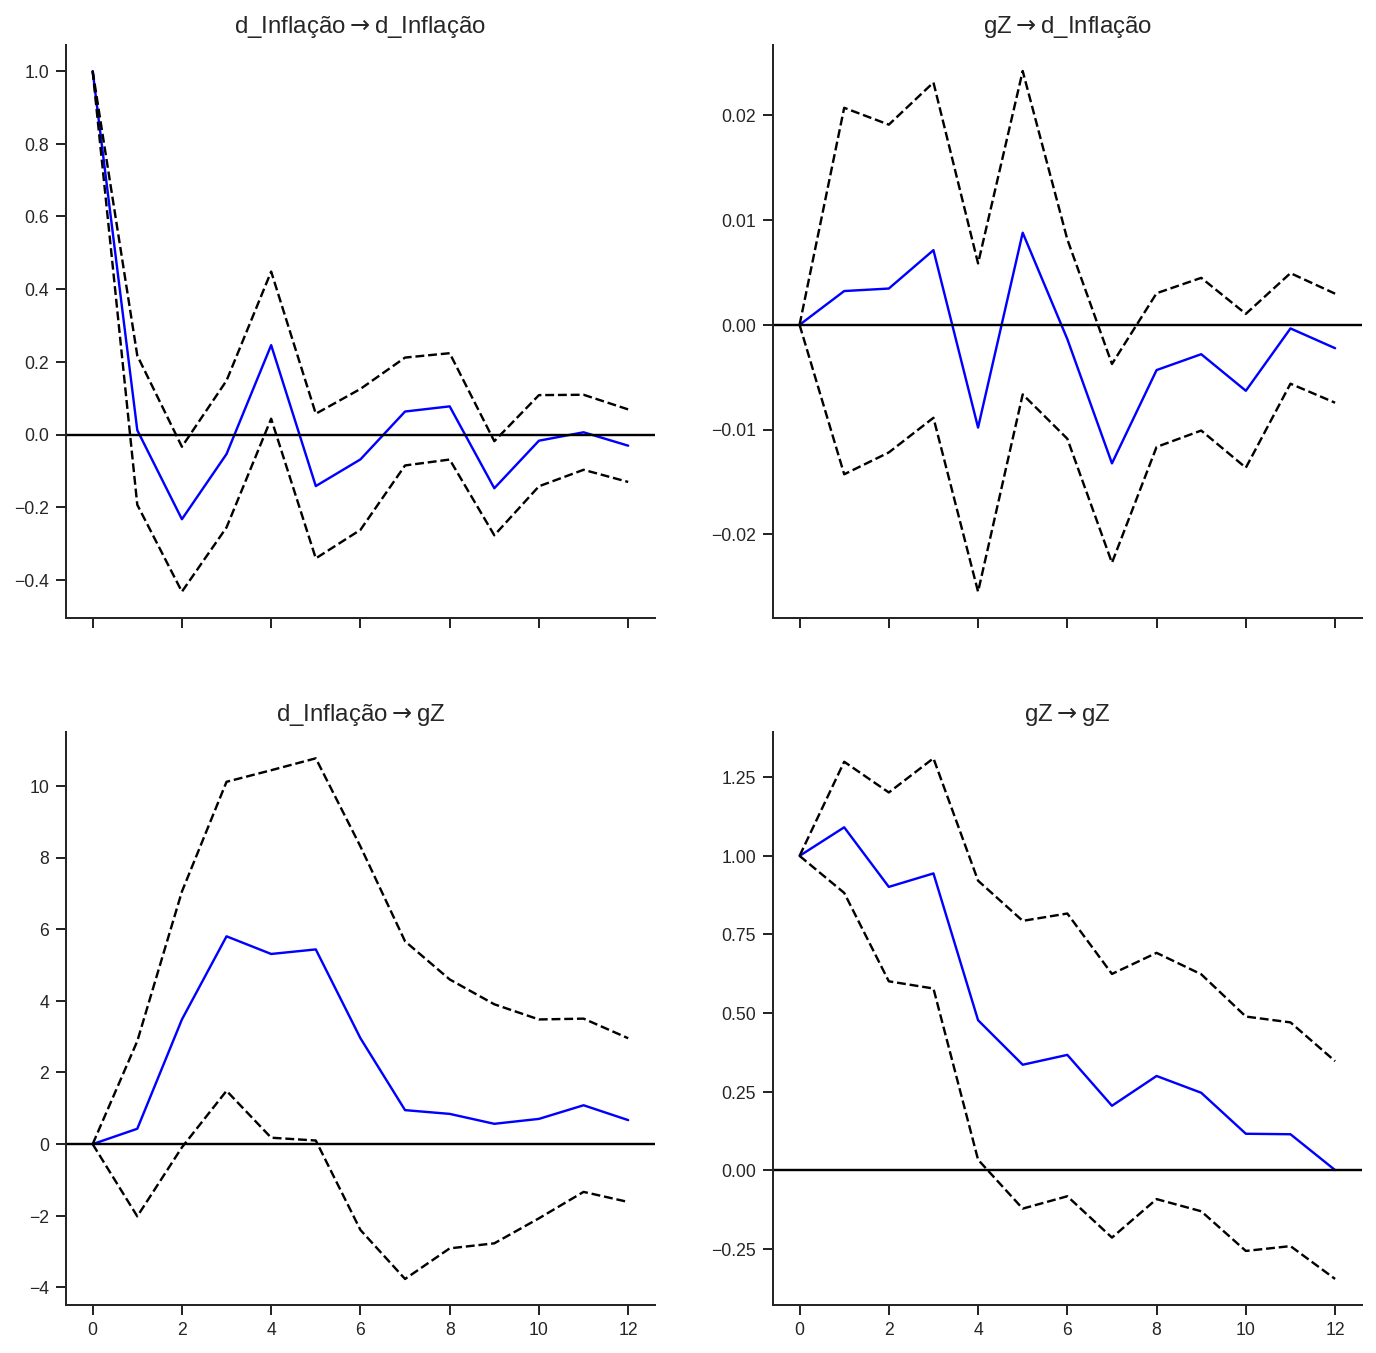

In [40]:
p = results.irf(12).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso.png", dpi = 300)

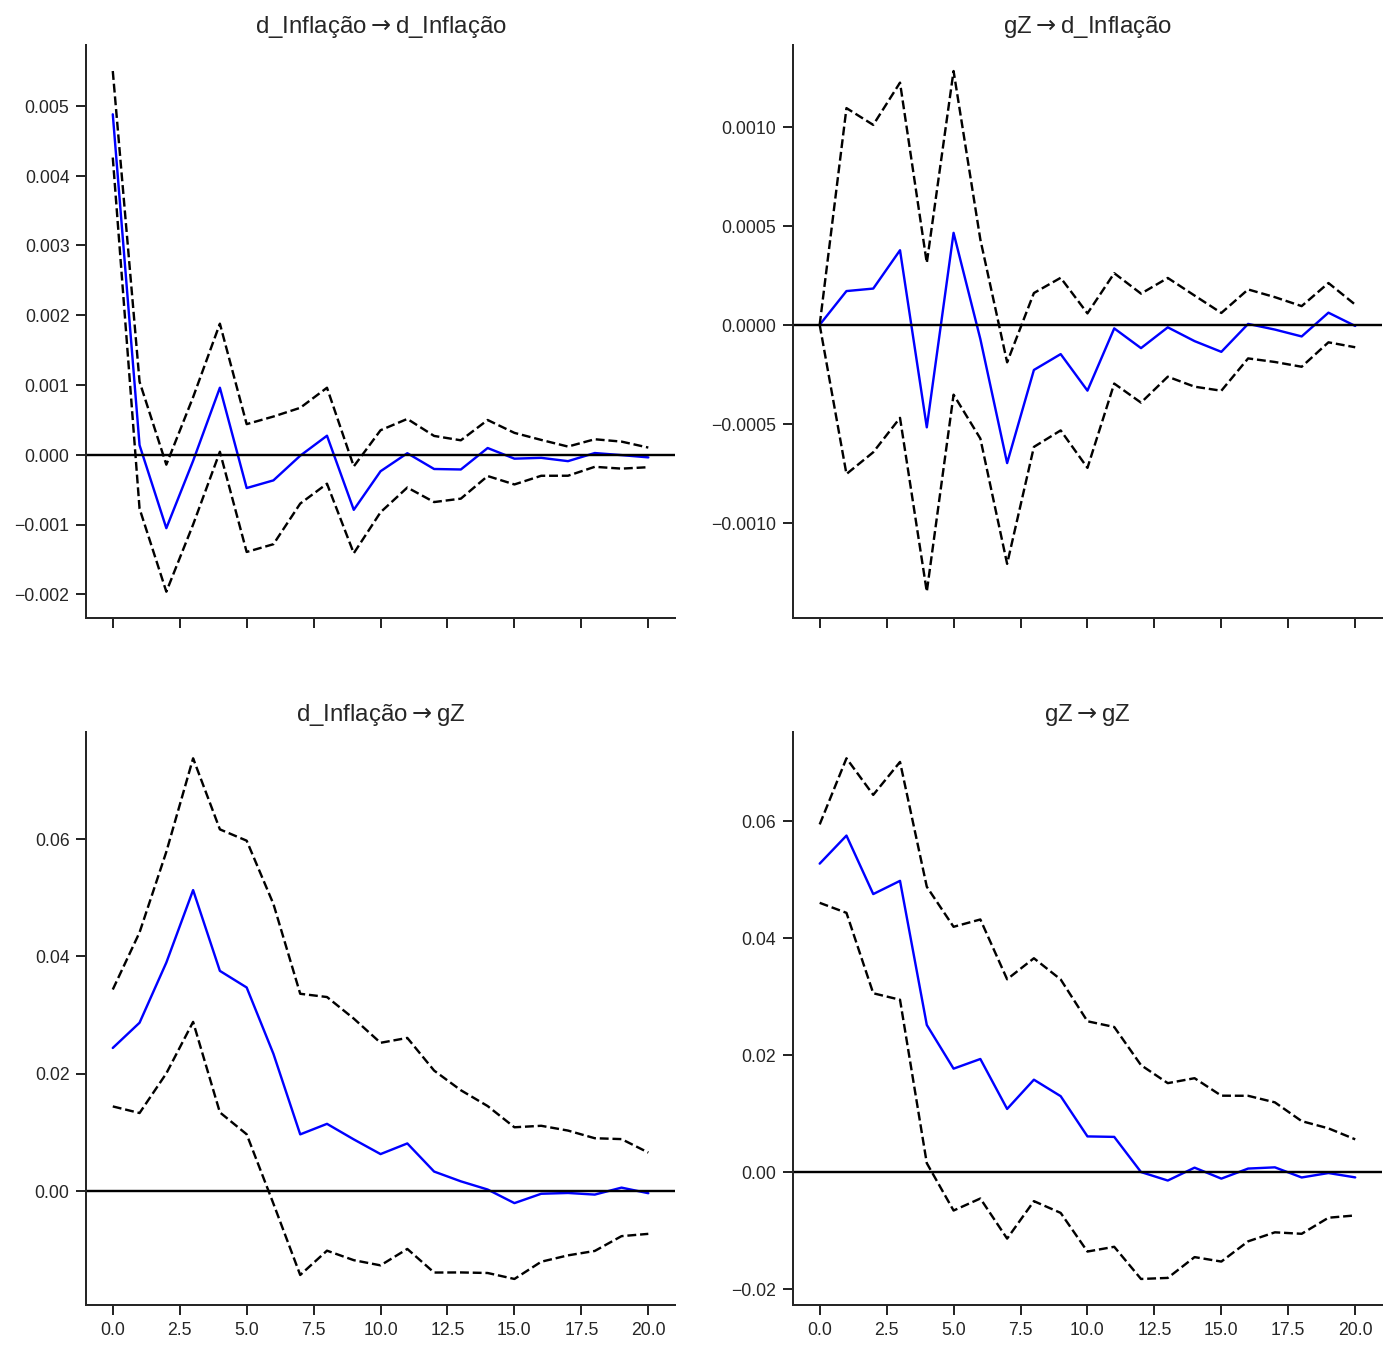

In [41]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Orth.png", dpi = 300)

## Efeito cumulativo

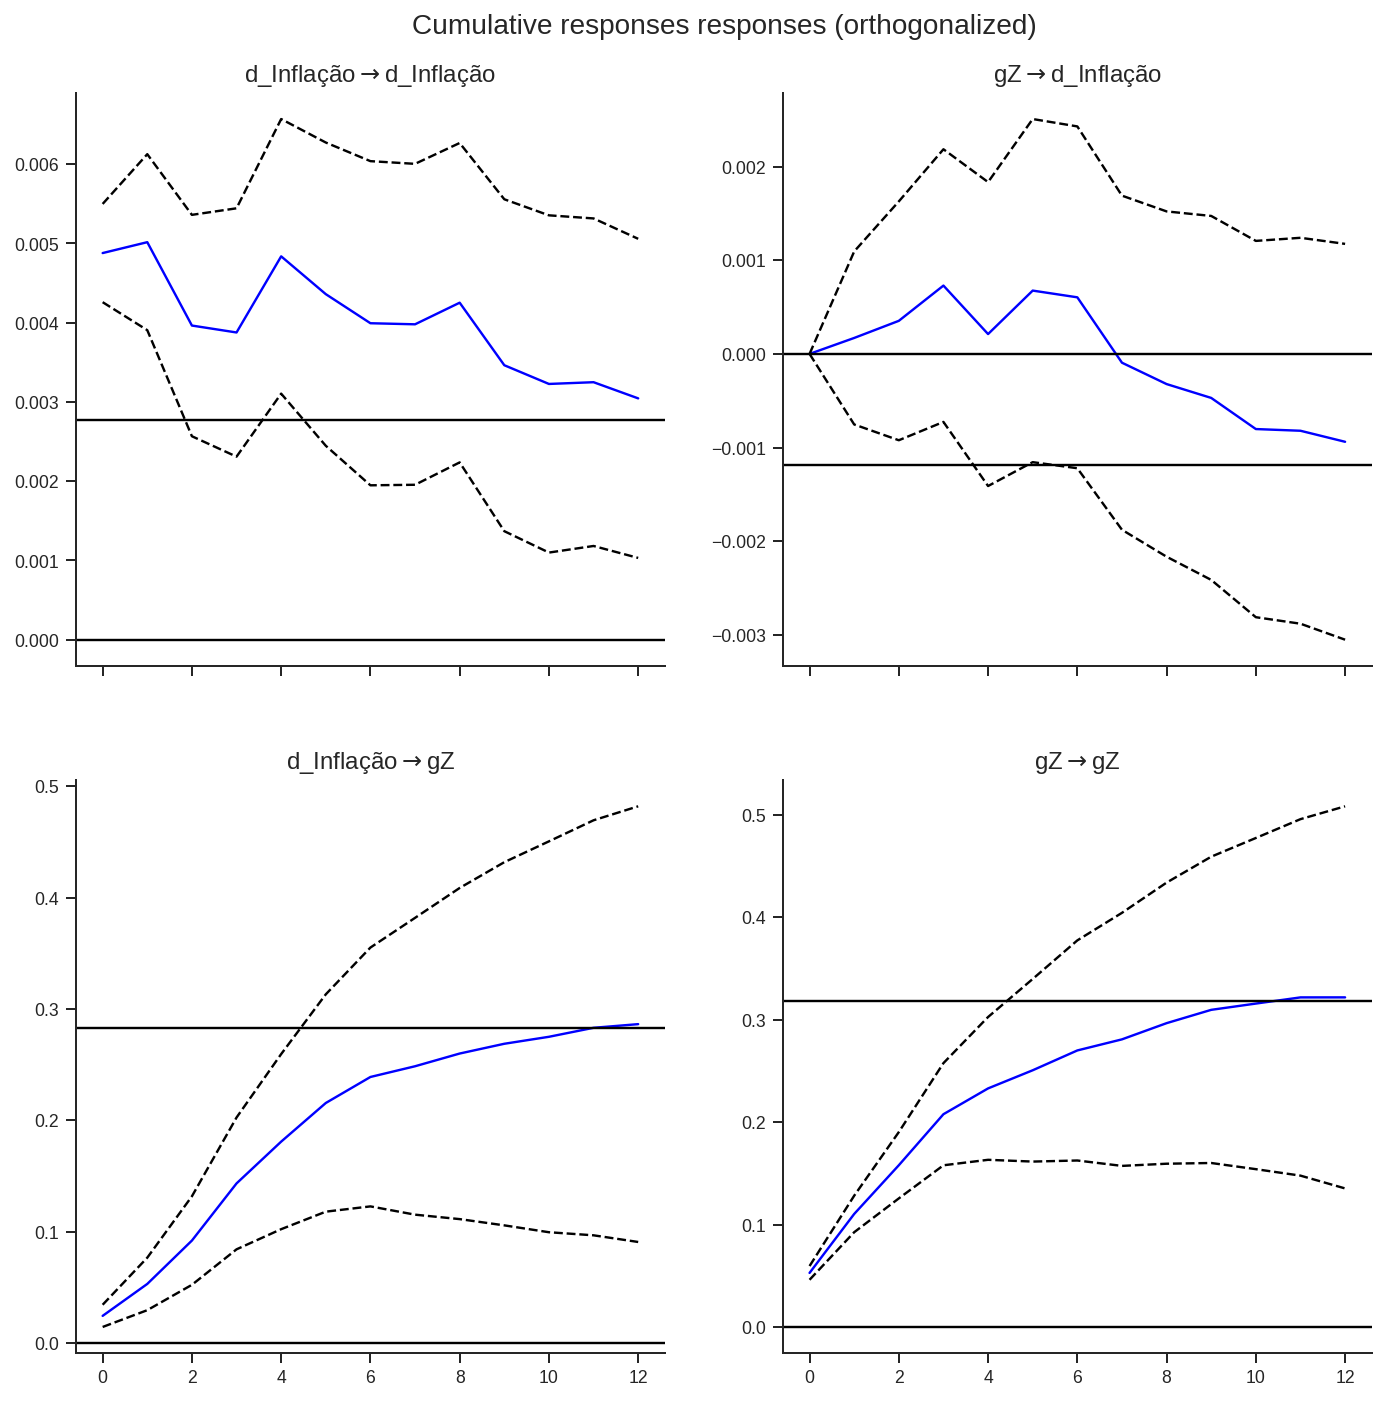

In [42]:
p = results.irf(12).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("./figs/Impulso_Cum.png", dpi = 300)

## Decomposição da variância

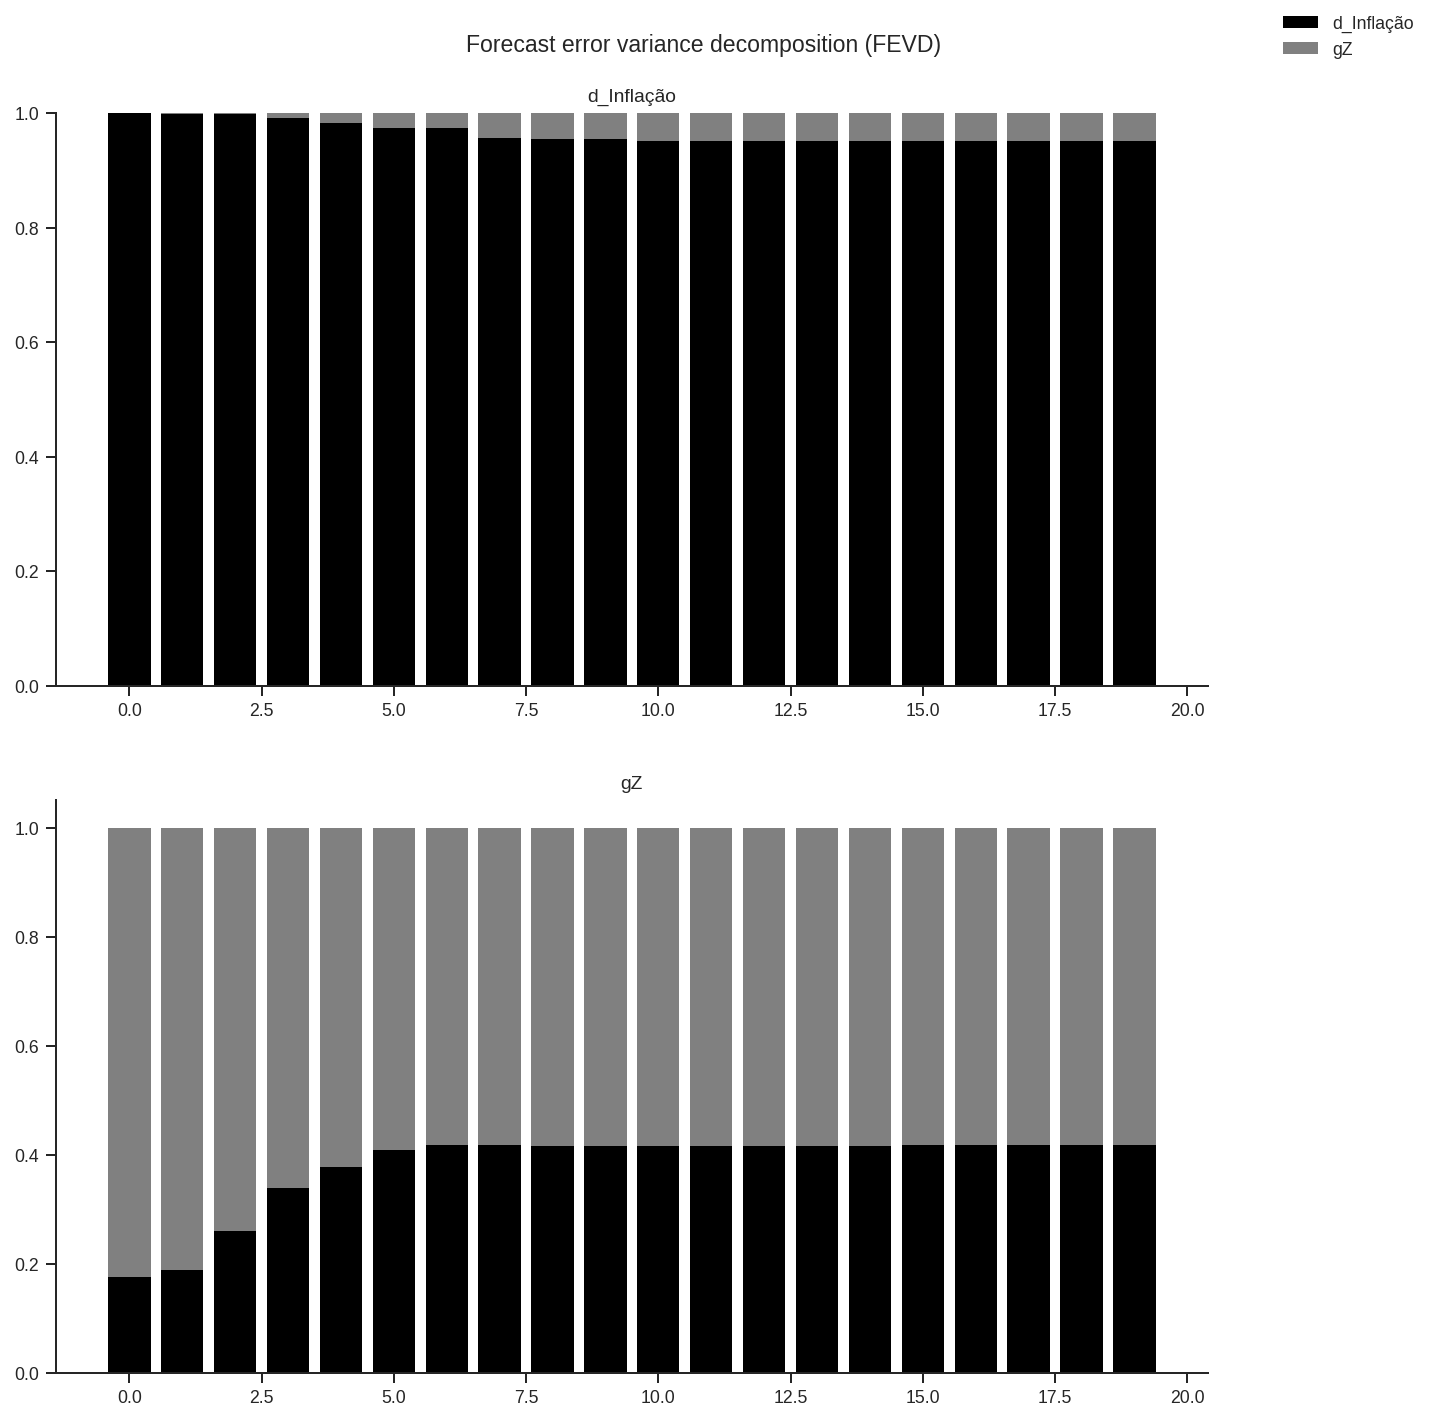

In [43]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("./figs/DecompVar.png", dpi = 300)